Due to Memory Constraints I needed to train on a batch size of 8 with a significantly smaller hidden + embeded size compared to the transformer. 
- This is because the memory required is effected by the sequence length

This is may be a reason for the accuracy of the model being only 80%.

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import pprint

import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pathlib import Path

from language_structure import *
from train import batch_iter, load
from model import *

base = Path('../aclImdb')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
testdf = pd.read_csv('test.csv')

In [2]:
model_path = 'e=0_itr=913_cancel_may28-1800'
model, optim, lang, metrics = load(model_path, cpu=True)

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(metrics)

{   'args': {   '--batch-size': '8',
                '--clip-grad': '5.0',
                '--dropout': '0.3',
                '--embed-size': '128',
                '--help': False,
                '--hidden-size': '128',
                '--load': False,
                '--load-from': 'default-model',
                '--log-every': '40',
                '--lr': '0.003',
                '--max-epoch': '30',
                '--max-sent-len': '800',
                '--n-heads': '2',
                '--n-layers': '3',
                '--n-valid': '500',
                '--n-words': '10000',
                '--qtest': False,
                '--save': True,
                '--save-to': 'may28-1800',
                '--seed': '0',
                '--valid-niter': '50',
                '--validate-every': '100'},
    'total_time': 416.726,
    'train_acc': [   0.5218750238418579,
                     0.6312500238418579,
                     0.6156250238418579,
                     0.737500011

Total Time: 416.726 
Train Time: 303.2929


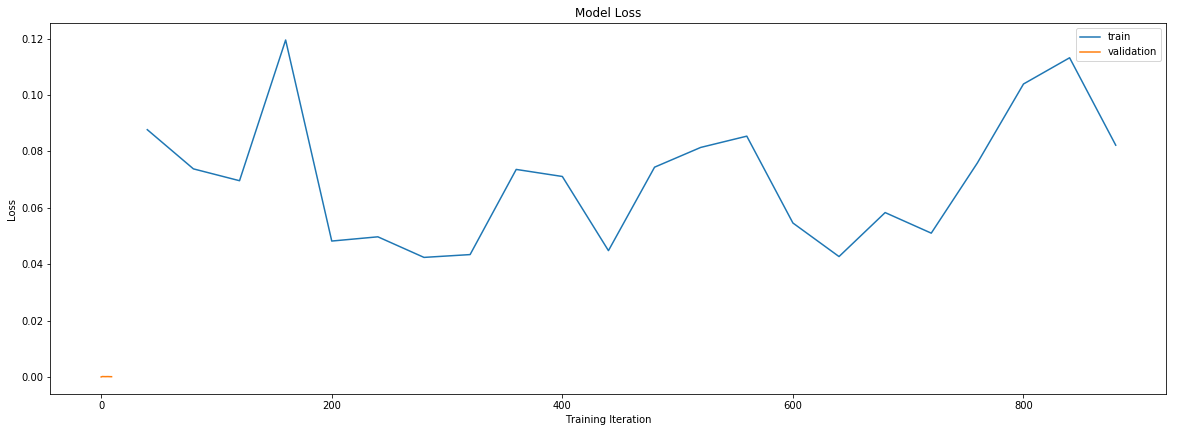

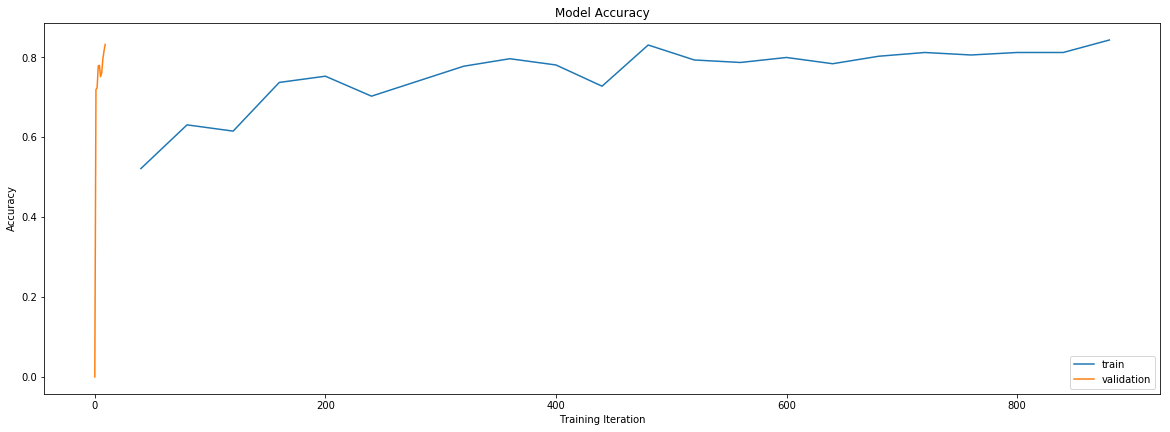

In [4]:
def format_sent(sentence):
    formatted_sentence = ['<start>', '0']
    idxs = list(range(1, len(sentence)+1))
    for (w, i) in list(zip(sentence, idxs)):
        formatted_sentence.append(w)
        formatted_sentence.append(str(i))
    formatted_sentence.append('<end>')
    formatted_sentence.append(str(len(idxs)+1))
    
    return ' '.join(formatted_sentence)

def plot_metrics(metrics):
    print("Total Time: {} \nTrain Time: {}".format(metrics['total_time'], metrics['train_time']))
    metrics['itr'] = list(range(len(metrics['train_loss'])))
    metrics['val_itr'] = list(range(len(metrics['val_loss'])))
    
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    figsize = (20, 15)
    plt.figure(1, figsize=figsize)                
    plt.subplot(211)
    plt.plot(metrics['train_iterations'], metrics['train_loss'],  label='train')
    plt.plot(metrics['val_itr'], metrics['val_loss'], label='validation')
    plt.legend()
    plt.xlabel('Training Iteration')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.show()
    
    # plot accuracy
    plt.figure(2, figsize=figsize)                # a second figure
    plt.subplot(212)
    plt.plot(metrics['train_iterations'], metrics['train_acc'], label='train')
    plt.plot(metrics['val_itr'], metrics['val_acc'], label='validation')
    plt.legend()
    plt.xlabel('Training Iteration')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    
    plt.show()
    
plot_metrics(metrics)

In [39]:
# Thanks to, 
# https://www.tensorflow.org/alpha/tutorials/text/nmt_with_attention
def plot_sentence_attention(sentence, batch_idx=None, target='N/A', attention_layer=0, n=5):
    
    model.eval()
    # Hook the Attention Weights
    attentions = model._modules.get('attention')
    tracked_attention_weigths = []
    def show(m, i, o): 
        w = o
        tracked_attention_weigths.append(w)
    hook = attentions.register_forward_hook(show)

    # get attention weights
    x = [sentence] if batch_idx == None else sentence
    y = target if batch_idx == None else target[batch_idx]
    
    h_x = model(x)
    pred_y = h_x if batch_idx == None else h_x[batch_idx]
    pred_y = pred_y.detach().numpy().squeeze()
    
    print("Predicted Value: %.2f True Value: %.2f" % (pred_y, y))
    hook.remove()
    w = tracked_attention_weigths[0]
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    
    attention = w.detach().numpy().squeeze()
    attention = attention if batch_idx == None else attention[batch_idx]
    
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}

#     ax.set_title("{}-Layer Long-Sentence Attention".format(attention_layer))
#     print("{}-Layer Long-Sentence Attention".format(attention_layer))
    
    words = sentence if batch_idx == None else sentence[batch_idx]
    # filter through language model for <unk> tokens
    words = [lang.id2word[d] for d in [lang.get_id(w) for w in words]]
    
#     if len(words) < 50: 
    ax.set_xticklabels([''] + words, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + words, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()
    
    print("{} Most Paid Attention Too Words".format(n))
    ind = np.argpartition(np.sum(attention, axis=0), -n)[-n:]
    print("\n".join(["{} - {} : {}".format(i, words[i], ' '.join(words[max(0, i-5):min(i+5, len(words))])) for i in ind]))
    print()
    
    print("{} Words Which Attended To The Most Words".format(n))
    ind = np.argpartition(np.sum(attention, axis=1), -n)[-n:]
    print("\n".join(["{} - {} : {}".format(i, words[i], ' '.join(words[max(0, i-5):min(i+5, len(words))])) for i in ind]))
    
    return attention, format_sent(words)

In [35]:
# Sample Example from dataset
df = testdf[testdf.file_length > 100]
for sents, targets in batch_iter(lang, df, 8, shuffle=True):
    break

# > 100 Words Attention Analysis
Very small amount of attention 

Predicted Value: 0.91 True Value: 1.00


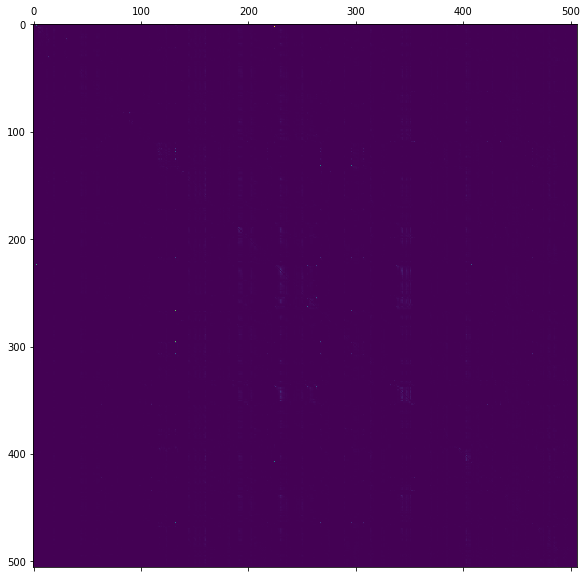

5 Most Paid Attention Too Words
347 - being : drained of its <unk> by being over <unk> . there
403 - who : point for any film lover who wants to see great
343 - of : un <unk> and not drained of its <unk> by being
230 - that : interview with francis coppola saying that he got the chance
160 - that : looking as the other stars that came before them but

5 Words Which Attended To The Most Words
485 - enjoy : have seen before and can enjoy today . amazon .
239 - because : chance to make the conversation because the producers knew he
19 - that : late sixties and early s that were a counter movement
234 - chance : saying that he got the chance to make the conversation
267 - voight : another interview is with jon voight who was directed by


In [34]:
batch_idx = 0
w, s = plot_sentence_attention(sents,
                        batch_idx=batch_idx,
                        target=targets,
                        attention_layer=0)

Predicted Value: 0.97 True Value: 1.00


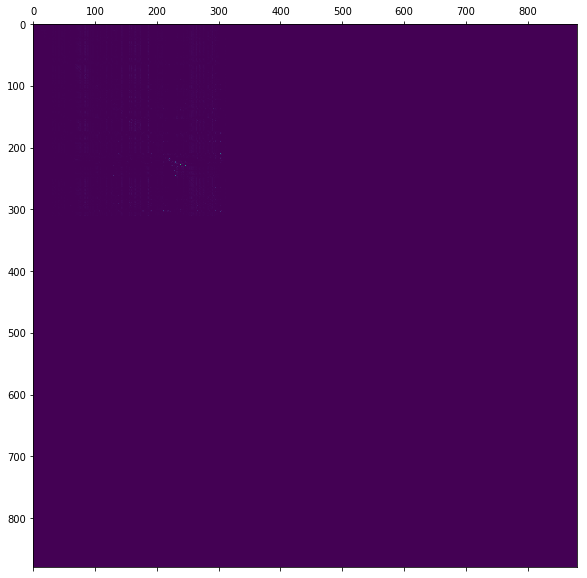

5 Most Paid Attention Too Words
84 - married : other and decide to get married . <unk> moves to
187 - in : family goes to the beach in a truck . many
260 - there : vhs released by <unk> <unk> there is information that <unk>
186 - beach : the family goes to the beach in a truck .
263 - that : <unk> <unk> there is information that <unk> <unk> was the

5 Words Which Attended To The Most Words
92 - lives : moves to <unk> house but lives in conflict with her
243 - <unk> : great performances and the actress <unk> <unk> is very beautiful
257 - by : of the brazilian vhs released by <unk> <unk> there is
278 - precise : i am not sure how precise are the subtitles in
11 - life : <unk> <unk> lives a <unk> life with her <unk> father


In [37]:
batch_idx = 1
w, s = plot_sentence_attention(sents,
                        batch_idx=batch_idx,
                        target=targets,
                        attention_layer=0)

# < 25 Words Attention Analysis
Very small amount of attention 

In [38]:
# Sample Example from dataset
df = testdf[testdf.file_length < 25]
for sents, targets in batch_iter(lang, df, 8, shuffle=True):
    break

Predicted Value: 0.87 True Value: 1.00


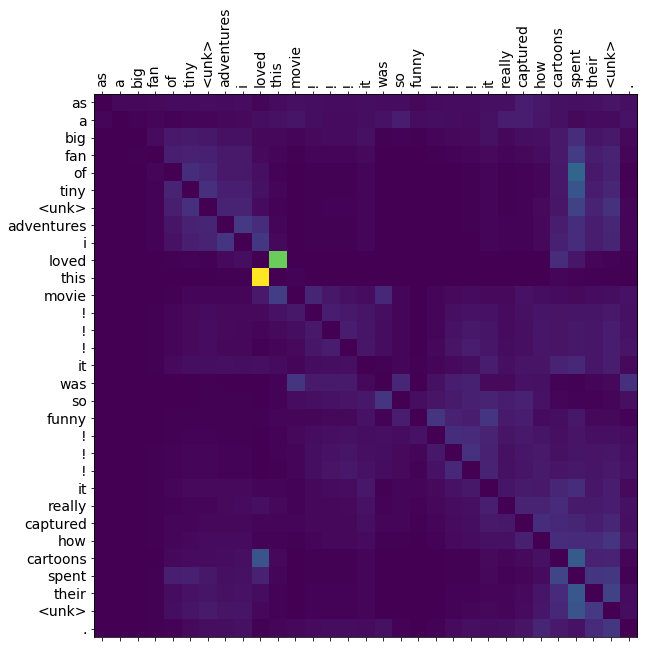

5 Most Paid Attention Too Words
28 - their : really captured how cartoons spent their <unk> .
9 - loved : of tiny <unk> adventures i loved this movie ! !
26 - cartoons : ! it really captured how cartoons spent their <unk> .
29 - <unk> : captured how cartoons spent their <unk> .
27 - spent : it really captured how cartoons spent their <unk> .

5 Words Which Attended To The Most Words
5 - tiny : as a big fan of tiny <unk> adventures i loved
15 - it : this movie ! ! ! it was so funny !
3 - fan : as a big fan of tiny <unk> adventures
25 - how : ! ! it really captured how cartoons spent their <unk>
9 - loved : of tiny <unk> adventures i loved this movie ! !


In [40]:
batch_idx = 0
w, s = plot_sentence_attention(sents,
                        batch_idx=batch_idx,
                        target=targets,
                        attention_layer=0)

Predicted Value: 0.76 True Value: 1.00


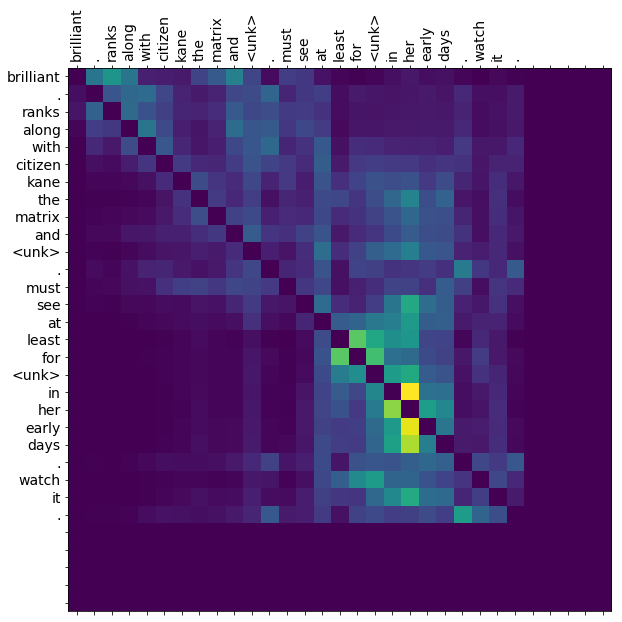

5 Most Paid Attention Too Words
21 - days : for <unk> in her early days . watch it .
20 - early : least for <unk> in her early days . watch it
17 - <unk> : must see at least for <unk> in her early days
19 - her : at least for <unk> in her early days . watch
18 - in : see at least for <unk> in her early days .

5 Words Which Attended To The Most Words
10 - <unk> : citizen kane the matrix and <unk> . must see at
12 - must : the matrix and <unk> . must see at least for
6 - kane : . ranks along with citizen kane the matrix and <unk>
14 - at : and <unk> . must see at least for <unk> in
13 - see : matrix and <unk> . must see at least for <unk>


In [43]:
batch_idx = 2
w, s = plot_sentence_attention(sents,
                        batch_idx=batch_idx,
                        target=targets,
                        attention_layer=0)

Notice RNN attention is much more symmetric compared to the transformers straight lines downwards. 
    - This is becuase RNN attention is placed after the encoding, while Transformer is calculated from different projections from the Query-Key-Value.
The projections are not exactly symmetric because of the softmax.
